In [ ]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import tensorflow as tf

# 1. Load the dataset

In [ ]:
### unzip training and test datasets.
# !apt-get install unzip
# !unzip ./sentiment-analysis-on-movie-reviews/test.tsv.zip test.tsv
# !unzip ./sentiment-analysis-on-movie-reviews/train.tsv.zip train.tsv
# !unzip ./sentiment-analysis-on-movie-reviews/train.tsv.zip train.tsv

In [14]:
df = pd.read_csv('train.tsv', sep='\t')
df_test=pd.read_csv('test.tsv', sep='\t')
sample_submission = pd.read_csv('./sentiment-analysis-on-movie-reviews/sampleSubmission.csv')

In [15]:
df.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [16]:
df_test.head()

,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine ...
1,156062,8545,An intermittently pleasing but mostly routine ...
2,156063,8545,An
3,156064,8545,intermittently pleasing but mostly routine effort
4,156065,8545,intermittently pleasing but mostly routine


In [17]:
df.shape, df_test.shape

((156060, 4), (66292, 3))

We can see that df_test's Sentiment/label is not available, thus we need to create our own test dataset for evaluation.

# 2. Split into train(validation within it) and test

In [20]:
df_train, df_test = train_test_split(df, test_size = 0.1, random_state = 3) #test:train = 1:9

# 3. Data Analytics

## 3.1 Dataset overview

In [21]:
df_train.shape, df_test.shape

((140454, 4), (15606, 4))

In [22]:
df_train.head()

,PhraseId,SentenceId,Phrase,Sentiment
151793,151794,8283,messy emotions,2
144411,144412,7840,"Man , Heart",2
116367,116368,6205,annoyed,1
37456,37457,1778,"its exquisite acting , inventive screenplay , ...",4
2961,2962,112,postcard,2


In [23]:
df_test.head()

,PhraseId,SentenceId,Phrase,Sentiment
104526,104527,5516,bomb,0
135932,135933,7343,"as a bonus ,",2
150608,150609,8209,Even on its own ludicrous terms,2
62279,62280,3148,Quitting hits home with disorienting force .,3
109780,109781,5816,found writer-director Mitch Davis 's wall of k...,1


Above we can see that Phrase and Sentiment columns are all we need from the file in order to train the models later, therefore we will use these as feature (X) and label (Y) when fitting the transformer.

## 3.2 Check if there is null/empty value

In [24]:
df_train.info(), df_train.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156060 entries, 0 to 156059
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   PhraseId    156060 non-null  int64 
 1   SentenceId  156060 non-null  int64 
 2   Phrase      156060 non-null  object
 3   Sentiment   156060 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 4.8+ MB


(None,
 PhraseId      0
 SentenceId    0
 Phrase        0
 Sentiment     0
 dtype: int64)

## 3.3 Class Distribution

The dataset looks good and we need to know how are distributed the 5 classes in the label so as to know it's balanced or not.

In [25]:
df_train.Sentiment.value_counts()

2    71624
3    29626
1    24545
4     8288
0     6371
Name: Sentiment, dtype: int64

The sentiment labels are:

0 - negative
1 - somewhat negative
2 - neutral
3 - somewhat positive
4 - positive

<AxesSubplot:title={'center':'Pie chart of Sentiment Class'}, ylabel='Sentiment'>

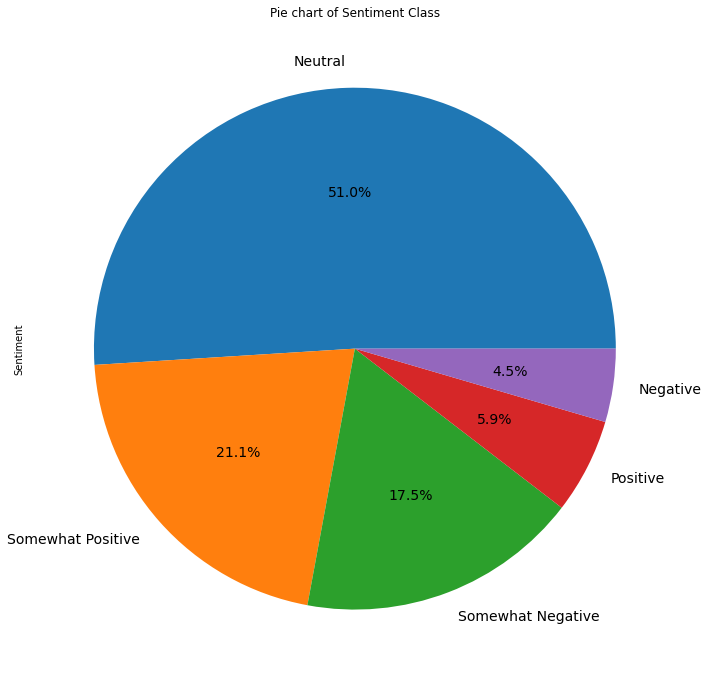

In [28]:
df2 = df_train.copy(deep = True) ## copy the dataset deeply
pie1 = pd.DataFrame(df2['Sentiment'].replace(0,'Negative').replace(1,'Somewhat Negative').replace(2,'Neutral').replace(3,'Somewhat Positive').replace(4,'Positive').value_counts())
pie1.reset_index(inplace = True)
pie1.plot(kind = 'pie', title = 'Pie chart of Sentiment Class',y = 'Sentiment',
          autopct = '%1.1f%%', shadow = False, labels = pie1['index'], legend = False, fontsize = 14, figsize = (12,12))

The label is considerably unbalanced, only 'Neutral' corresponds to more than 50% of instances and there is a slightly skewed towards positive reviews. Early we can say the class to be predicted will be sidetracked toward the more frequent classes, this is why we need a text balancing technique just like 'SMOTE' for numerical features.

## 3.4 No.words Distribution

Time now to find out the number of words in reviews, in order to understand a bit better we will plot histograms for each class

In [41]:
# df_train[df_train['Sentiment'] == 0]['Phrase'].str.split().map(lambda x: len(x))

Text(0.5, 0.98, 'Histogram number of words in reviews')

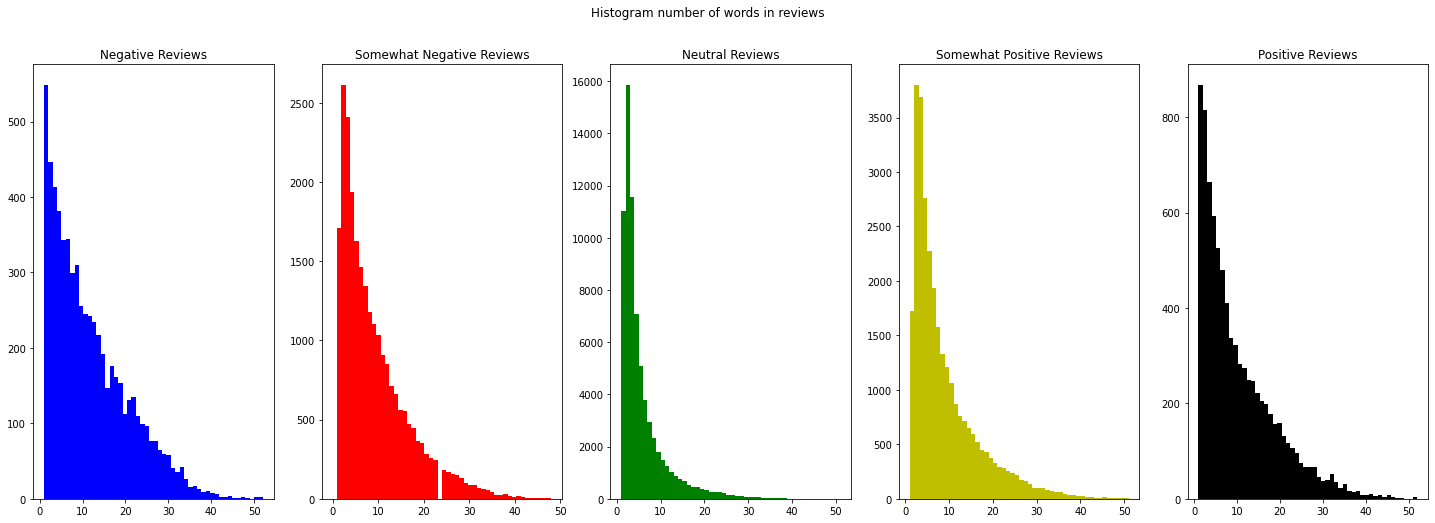

In [40]:
f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5,figsize=(25,8))

ax1.hist(df_train[df_train['Sentiment'] == 0]['Phrase'].str.split().map(lambda x: len(x)), bins=50, color='b')
ax1.set_title('Negative Reviews')

ax2.hist(df_train[df_train['Sentiment'] == 1]['Phrase'].str.split().map(lambda x: len(x)), bins=50, color='r')
ax2.set_title('Somewhat Negative Reviews')

ax3.hist(df_train[df_train['Sentiment'] == 2]['Phrase'].str.split().map(lambda x: len(x)), bins=50, color='g')
ax3.set_title('Neutral Reviews')

ax4.hist(df_train[df_train['Sentiment'] == 3]['Phrase'].str.split().map(lambda x: len(x)), bins=50, color='y')
ax4.set_title('Somewhat Positive Reviews')

ax5.hist(df_train[df_train['Sentiment'] == 4]['Phrase'].str.split().map(lambda x: len(x)), bins=50, color='k')
ax5.set_title('Positive Reviews')

f.suptitle('Histogram number of words in reviews')

In the 5 histograms we can see the distribution behaves like a negative exponential function decreasing significantly as the x-axis increases. It seems like the longest sentence in Phrase column corresponds to a class 'Negative Reviews' and is around 52 words, now let's obtain the longest one by using the max() function:

In [42]:
df_train['Phrase'].str.split().map(lambda x: len(x)).max()

52

Effectively was 52 words, this means if we would Tokenize by word the max_length should be 52, however as transformers consider sub-words tokenization such number could be increased depending on the words being used which can increase such length to 60 or even more, thus we have to take that into account when modeling as it could cause our model to take significatively a long time to train, therefore we have to find a trade-off between training time and performance.

In [43]:
df20=pd.DataFrame(df_train['Phrase'].str.split().map(lambda x: len(x))>=20)
print('Number of sentences which contain more than 20 words: ', df20.loc[df20['Phrase']==True].shape[0])
print(' ')
df30=pd.DataFrame(df_train['Phrase'].str.split().map(lambda x: len(x))>=30)
print('Number of sentences which contain more than 30 words: ', df30.loc[df30['Phrase']==True].shape[0])
print(' ')
df40=pd.DataFrame(df_train['Phrase'].str.split().map(lambda x: len(x))>=40)
print('Number of sentences which contain more than 40 words: ', df40.loc[df40['Phrase']==True].shape[0])
print(' ')
df50=pd.DataFrame(df_train['Phrase'].str.split().map(lambda x: len(x))>=50)
print('Number of sentences which contain more than 50 words: ', df50.loc[df50['Phrase']==True].shape[0])
print(' ')
df52=pd.DataFrame(df_train['Phrase'].str.split().map(lambda x: len(x))==52)
print('Number of sentences which contain 52 words: ', df52.loc[df52['Phrase']==True].shape[0])
print(' ')
#dfff.loc[dfff['Phrase']==True]

Number of sentences which contain more than 20 words:  10311
 
Number of sentences which contain more than 30 words:  2315
 
Number of sentences which contain more than 40 words:  316
 
Number of sentences which contain more than 50 words:  16
 
Number of sentences which contain 52 words:  3
 


Above we see 316 reviews contain more than 40 words and only 16 reviews above 50 words, these two number corresponds to a tiny proportion of the total number of instances (140,454), therefore setting to these numbers will not affect too much the classification. Below we can see an example of a sentence containing 52 words, observe there are misspelled words, acronyms and some of them can be decomposed into sub-words:

In [45]:
print(df_train.loc[87835,'Phrase'])

There are n't too many films that can be as simultaneously funny , offbeat and heartwarming -LRB- without a thick shmear of the goo , at least -RRB- , but `` Elling '' manages to do all three quite well , making it one of the year 's most enjoyable releases .


# 4. Prepeartion

## 4.1 Install transformers

Firstly, we have to install the transformers library offered by HuggingFace so as enable all useful functions when building the four models.

In [46]:
!pip install transformers

     |████████████████████████████████| 4.0 MB 9.4 MB/s eta 0:00:01
     |████████████████████████████████| 189 kB 27.6 MB/s eta 0:00:01
     |████████████████████████████████| 3.6 MB 57.2 MB/s eta 0:00:01
     |████████████████████████████████| 289 kB 29.1 MB/s eta 0:00:01
     |████████████████████████████████| 78 kB 39.7 MB/s eta 0:00:01
     |████████████████████████████████| 77 kB 24.4 MB/s eta 0:00:01
     |████████████████████████████████| 895 kB 25.5 MB/s eta 0:00:01
     |████████████████████████████████| 63 kB 11.4 MB/s eta 0:00:01
     |████████████████████████████████| 138 kB 28.9 MB/s eta 0:00:01
     |████████████████████████████████| 61 kB 11.1 MB/s eta 0:00:01
     |████████████████████████████████| 96 kB 8.8 MB/s  eta 0:00:01


## 4.2 Extract useful features and labels

Now we have to gather from the dataset only the two columns useful for training (Phrase and Sentiment):

In [58]:
data = df_train[['Phrase', 'Sentiment']]

# Set your model output as categorical and save in new label col
data['Sentiment_label'] = pd.Categorical(data['Sentiment'])

# Transform your output to numeric
data['Sentiment'] = data['Sentiment_label'].cat.codes

/Users/wxy/opt/anaconda3/envs/AMLS2/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/wxy/opt/anaconda3/envs/AMLS2/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [56]:
data

,Phrase,Sentiment,Sentiment_label
151793,messy emotions,2,2
144411,"Man , Heart",2,2
116367,annoyed,1,1
37456,"its exquisite acting , inventive screenplay , ...",4,4
2961,postcard,2,2
...,...,...,...
11261,the years,2,2
104704,best sequel,4,4
48056,the last 100 years,2,2
77049,in which murder is casual and fun,2,2


## 4.3 Split the training set into training and validation dataset

Split into train and validation set, as the file contains more than 140 thousand instances we can consider only a small portion of it as validation and still the number is relatively long, because of this we will set the test_size to 10% as follows:

In [57]:
data_train, data_val = train_test_split(data, test_size = 0.1, random_state = 1)

## 5. Bert

As first step we have to import the Model, Config and Tokenizer corresponding to Bert in order to build properly the model.

In [60]:
from transformers import TFBertModel,  BertConfig, BertTokenizerFast

None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


The model we will use is 'bert_base_uncased' and the max_length chosen is 45 as there are only a very small number of larger sequences.

In [61]:
# Name of the BERT model to use
model_name = 'bert-base-uncased'

# Max length of tokens
max_length = 45

# Load transformers config and set output_hidden_states to False
config = BertConfig.from_pretrained(model_name)
config.output_hidden_states = False

# Load BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained(pretrained_model_name_or_path = model_name, config = config)

# Load the Transformers BERT model
transformer_bert_model = TFBertModel.from_pretrained(model_name, config = config)

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

ImportError: 
TFBertModel requires the TensorFlow library but it was not found in your environment. Checkout the instructions on the
installation page: https://www.tensorflow.org/install and follow the ones that match your environment.
